In [109]:
import pandas as pd
import numpy as np
from PCA import PCA
from Model import KMeans
from Model import GaussianMixtureModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [110]:
def load_data(dataset_path):
    data = pd.read_csv("Datasets/"+ dataset_path)
    data = data.drop('time', axis=1)
    return data

In [111]:
def normalization(data):
    demean = data - data.mean()
    unit_variance = demean / data.std()
    return unit_variance

In [112]:
def pairwise_distances(X):
    num_points = X.shape[0]
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i+1, num_points):
            distance_ij = np.linalg.norm(X[i] - X[j])
            distances[i, j] = distance_ij
            distances[j, i] = distance_ij
    return distances


def calculate_scatter(cluster_points, centroid):
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    return np.mean(distances)

def davies_bouldin_score(X, labels, centroids):
    n_clusters = len(np.unique(labels))
    cluster_scatters = np.zeros(n_clusters)

    for i in range(n_clusters):
        cluster_points = X[labels == i]
        centroid = centroids[i]
        cluster_scatters[i] = calculate_scatter(cluster_points, centroid)

    db_scores = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                db_scores[i, j] = (cluster_scatters[i] + cluster_scatters[j]) / pairwise_distances(centroids)[i,j]

    db_scores[np.isinf(db_scores)] = 0
    db_scores[np.isnan(db_scores)] = 0

    dbi = np.mean(np.max(db_scores, axis=1))
    return dbi

In [113]:
def GMM(data, n_components):
    model = GaussianMixtureModel(n_components)
    X = np.array(data)
    model.fit(X)
    predicted_labels = model.predict(X)
    means = model.means
    covariances = model.covariances
    return predicted_labels, means

In [114]:
dataset = load_data("Spellman.csv")

In [115]:
dbi_scores_kmeans = {}
for n_components in range(2,11):
    for k in [3,4]:
        pca = PCA(n_components)
        X = dataset.values
        pca.fit(X)
        transformed_data = pca.transform(X)
        kmeans = KMeans(k, random_state=42)
        y_pred = kmeans.fit_predict(transformed_data)
        dbi = davies_bouldin_score(transformed_data, kmeans.labels_, kmeans.centroids)
        dbi_scores_kmeans[("Kmeans",n_components, k)] = dbi

In [116]:
dbi_scores_gmm = {}
for n_components in range(2,11):
    for k in [3,4]:
        pca = PCA(n_components)
        X = dataset.values
        pca.fit(X)
        transformed_data = pca.transform(X)
        predicted_labels, centroids = GMM(transformed_data, k)
        dbi = davies_bouldin_score(transformed_data, predicted_labels, centroids)
        dbi_scores_gmm[("GMM",n_components, k)] = dbi

In [117]:
dbi_scores_kmeans = sorted(dbi_scores_kmeans.items(), key=lambda item: item[1])
dbi_scores_gmm = sorted(dbi_scores_gmm.items(), key=lambda item: item[1])

In [118]:
configs_kmeans = np.array([config[0] for config in dbi_scores_kmeans])
configs_gmm = np.array([config[0] for config in dbi_scores_gmm])

C:\Users\pars iran\AppData\Local\Temp\ipykernel_13124\3417840630.py:23: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  axes[count % 2].scatter(x, y, z, c=y_pred, cmap='viridis')


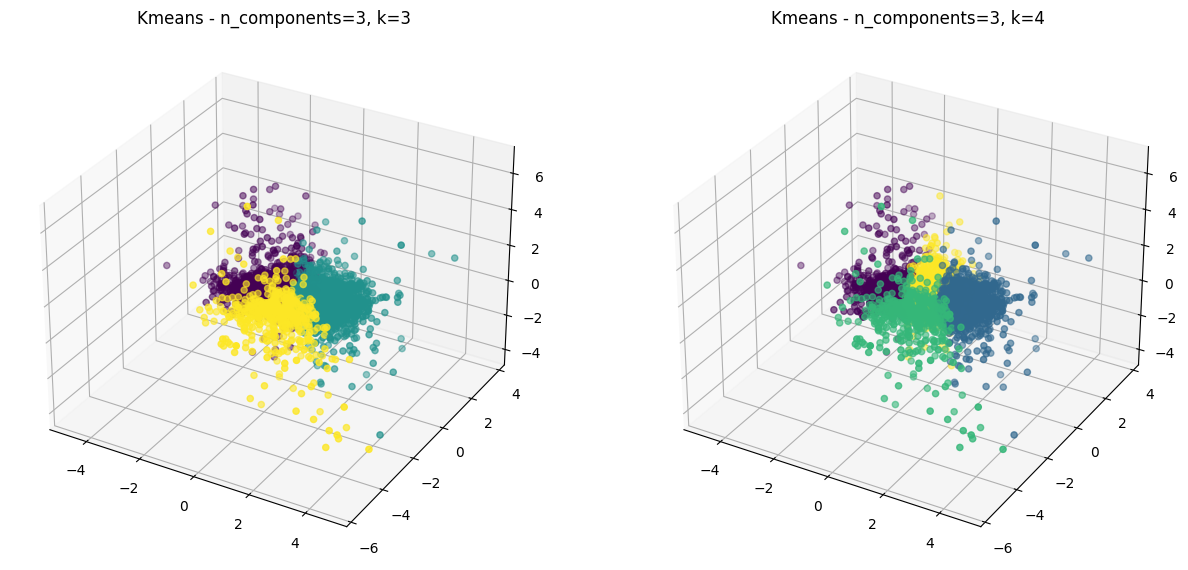

In [121]:
count = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

for method, n_components, k in configs_kmeans:
    n_components = int(n_components)
    k = int(k)
    if n_components == 2:
        continue
    if count > 1:
        break

    pca = PCA(n_components=n_components)
    X = dataset.values
    pca.fit(X)
    transformed_data = pca.transform(X)

    kmeans = KMeans(n_clusters=k, random_state=42)
    y_pred = kmeans.fit_predict(transformed_data)

    selected_components = np.sort(np.random.choice(transformed_data.shape[1], size=3, replace=False))
    x, y, z = transformed_data[:, selected_components].T

    axes[count % 2].scatter(x, y, z, c=y_pred, cmap='viridis')
    axes[count % 2].set_title(f"{method} - n_components={n_components}, k={k}")
    count += 1

plt.show()

C:\Users\pars iran\AppData\Local\Temp\ipykernel_13124\2591821190.py:21: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  axes[count % 2].scatter(x, y, z, c=y_pred, cmap='viridis')


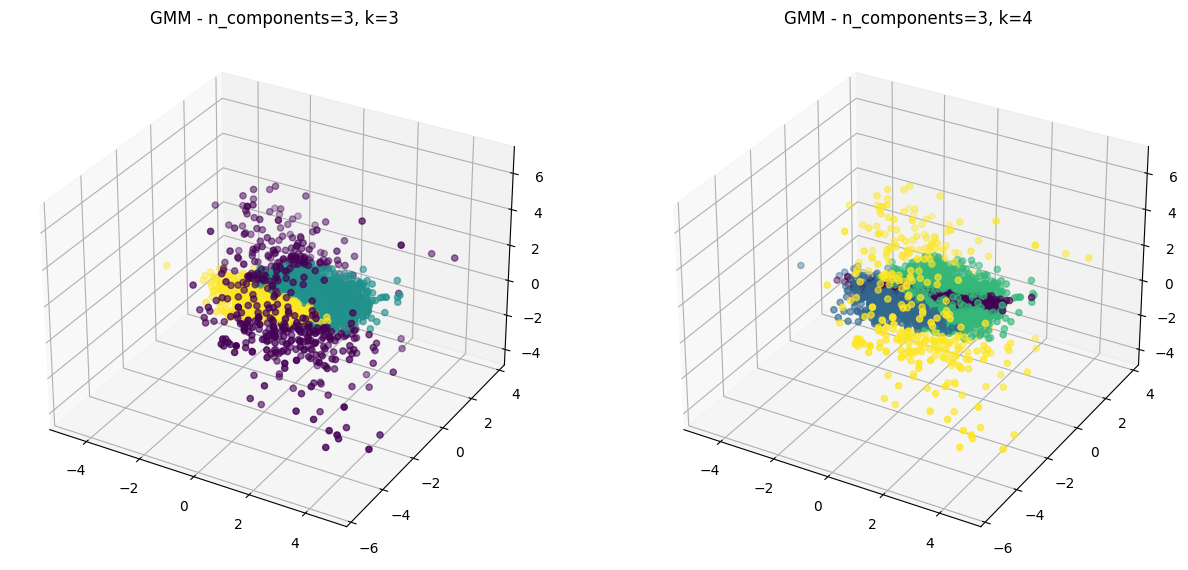

In [124]:
count = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

for method, n_components, k in configs_gmm:
    n_components = int(n_components)
    k = int(k)
    if n_components == 2:
        continue
    if count > 1:
        break

    pca = PCA(n_components=n_components)
    X = dataset.values
    pca.fit(X)
    transformed_data = pca.transform(X)

    y_pred, _ = GMM(transformed_data,k)
    selected_components = np.sort(np.random.choice(transformed_data.shape[1], size=3, replace=False))
    x, y, z = transformed_data[:, selected_components].T

    axes[count % 2].scatter(x, y, z, c=y_pred, cmap='viridis')
    axes[count % 2].set_title(f"{method} - n_components={n_components}, k={k}")
    count += 1

plt.show()